# Question 1

In [19]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft, fftfreq
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
import datetime

In [3]:
# Define parameters
amplitude = 5
frequency = 10  # Hz
duration = 0.5  # seconds
sampling_rate = 1000  # samples per second
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Define Fourier Transform plotting function
def plot_signal_and_fft(signal, title, xlabel='Time (s)', ylabel='Amplitude (V)'):
    # Compute Fourier Transform
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / sampling_rate)[:N // 2]

    # Plot time-domain and frequency-domain
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
    ax1.plot(t, signal)
    ax1.set_title(f"{title} - Time Domain")
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)

    ax2.plot(xf, 2.0 / N * np.abs(yf[:N // 2]))
    ax2.set_title(f"{title} - Fourier Transform")
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Magnitude')
    plt.tight_layout()
    plt.show()

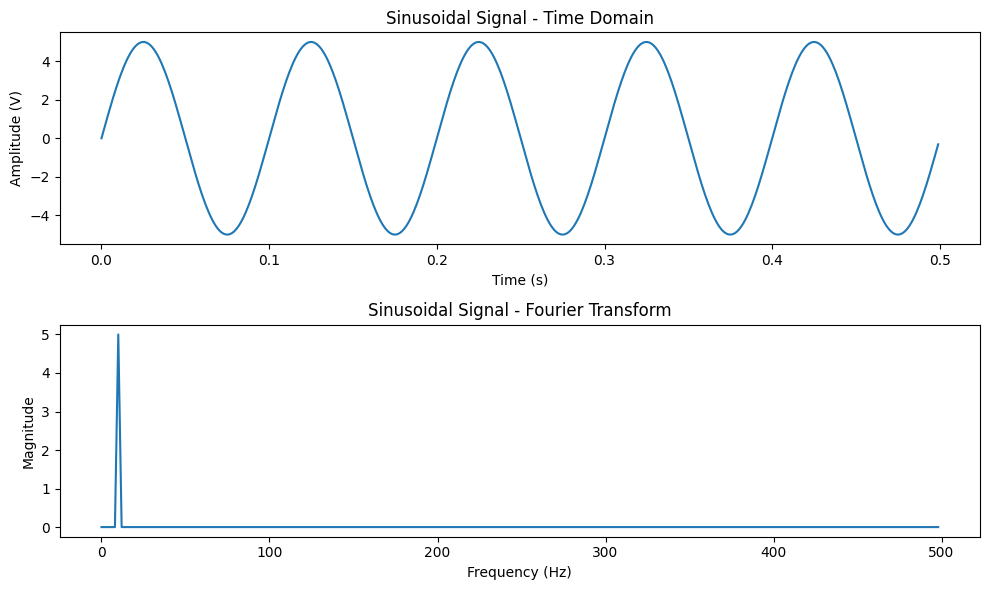

In [4]:
# (a) Sinusoidal Signal
sinusoidal_signal = amplitude * np.sin(2 * np.pi * frequency * t)
plot_signal_and_fft(sinusoidal_signal, "Sinusoidal Signal")

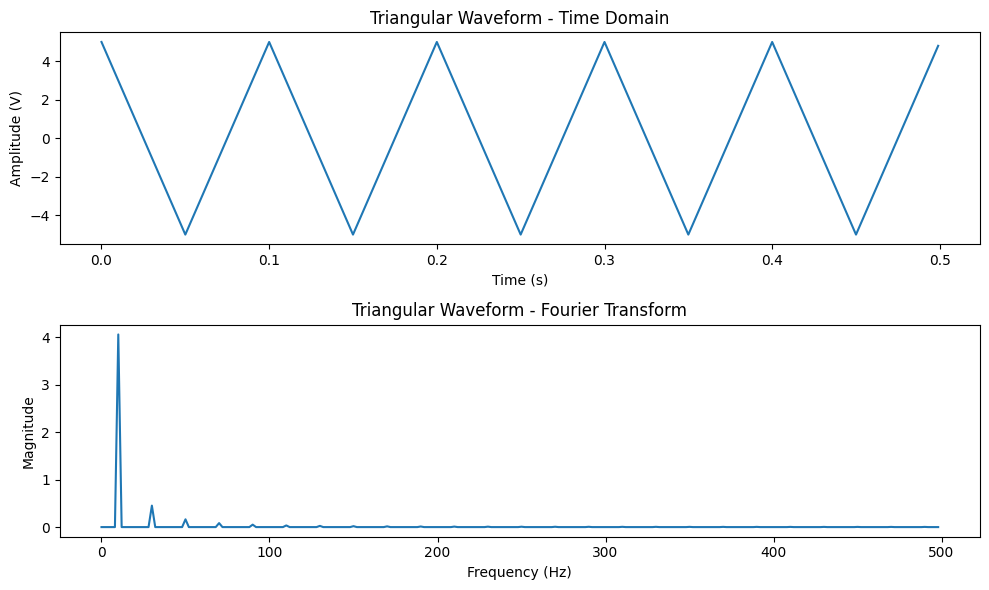

In [5]:
# (b) Triangular Waveform
triangular_signal = amplitude * np.abs(np.mod(t * frequency, 1) * 2 - 1) * 2 - amplitude
plot_signal_and_fft(triangular_signal, "Triangular Waveform")

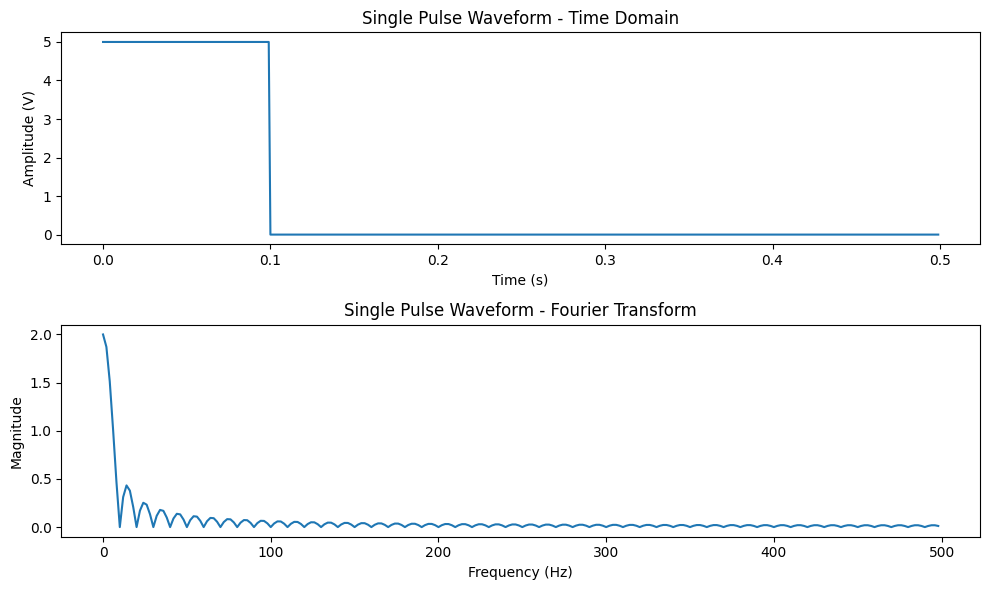

In [6]:
# (c) Single Pulse Waveform
pulse_single = np.zeros_like(t)
pulse_single[:int(0.2 * len(t))] = amplitude
plot_signal_and_fft(pulse_single, "Single Pulse Waveform")

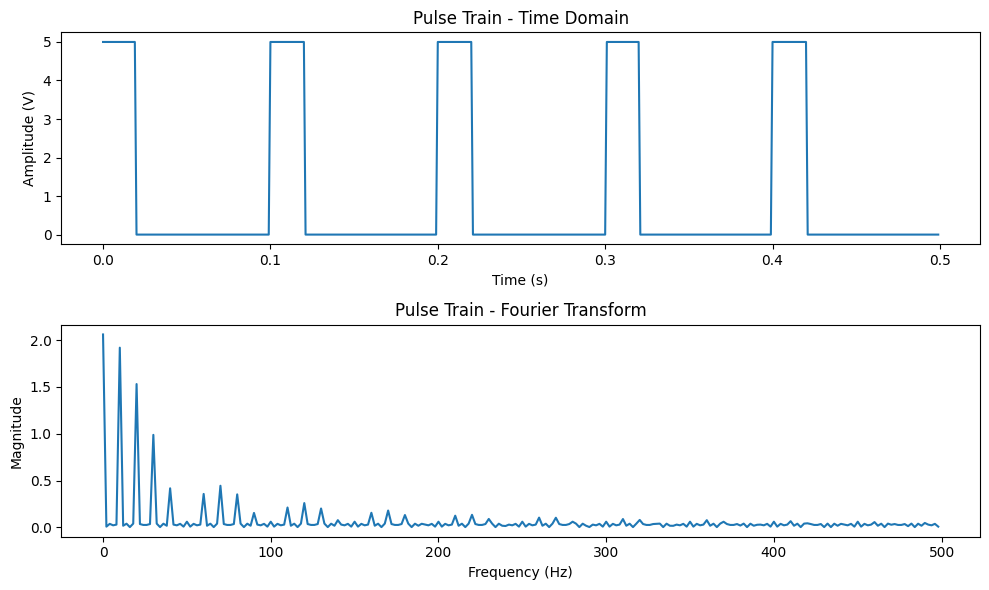

In [7]:
# (d) Pulse Train
pulse_train = (np.mod(t, 0.1) < 0.02).astype(float) * amplitude
plot_signal_and_fft(pulse_train, "Pulse Train")

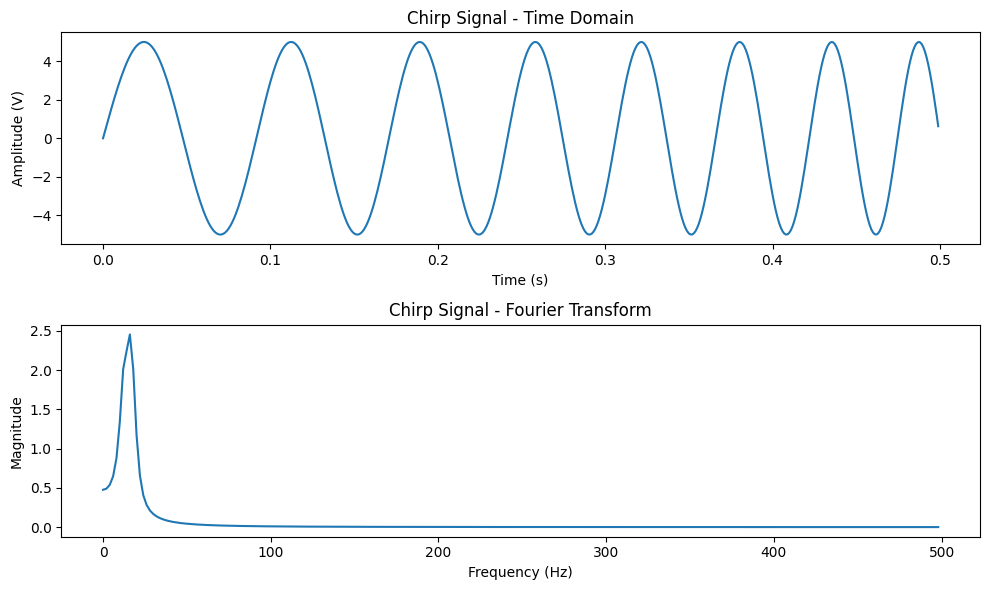

In [8]:
# (e) Chirp Signal
chirp_signal = amplitude * np.sin(2 * np.pi * (10 * t + (20 - 10) / (2 * duration) * t**2))
plot_signal_and_fft(chirp_signal, "Chirp Signal")

# Question 2

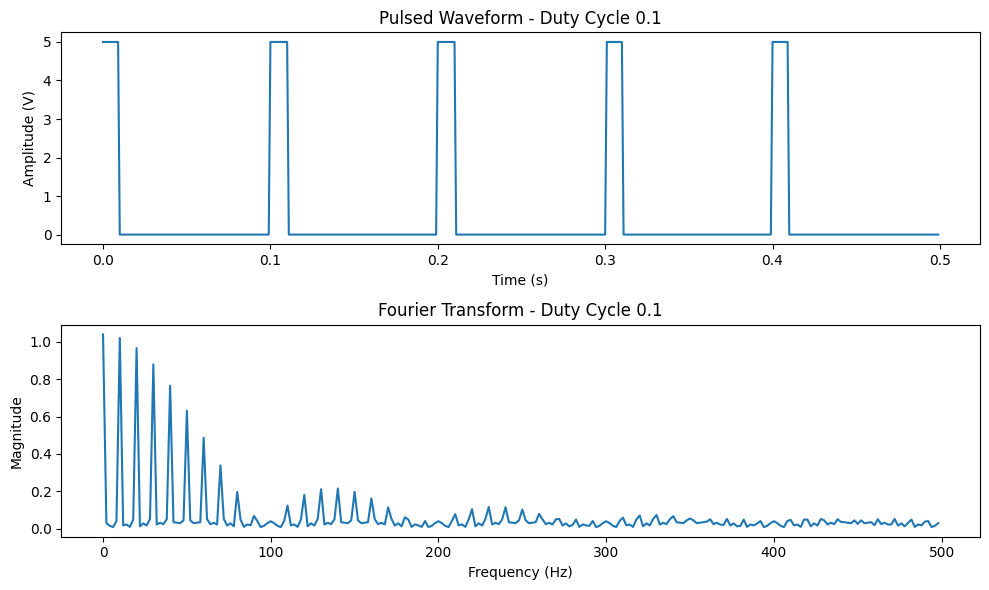

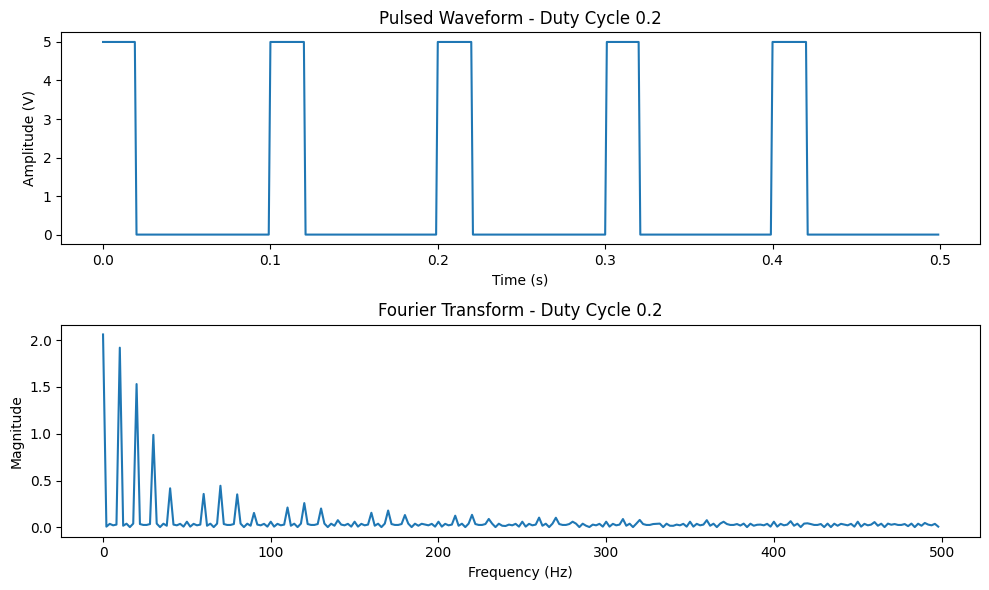

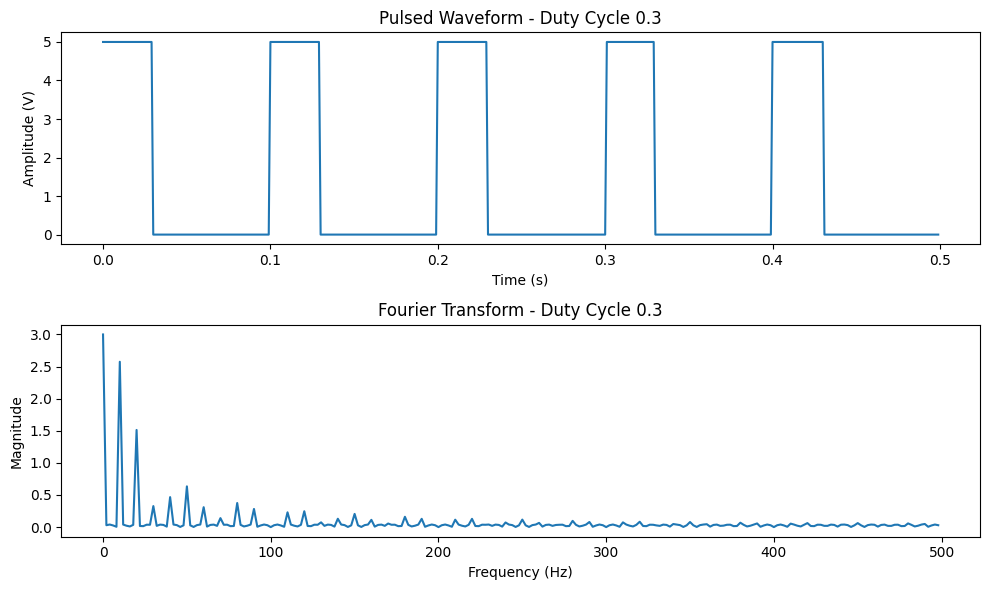

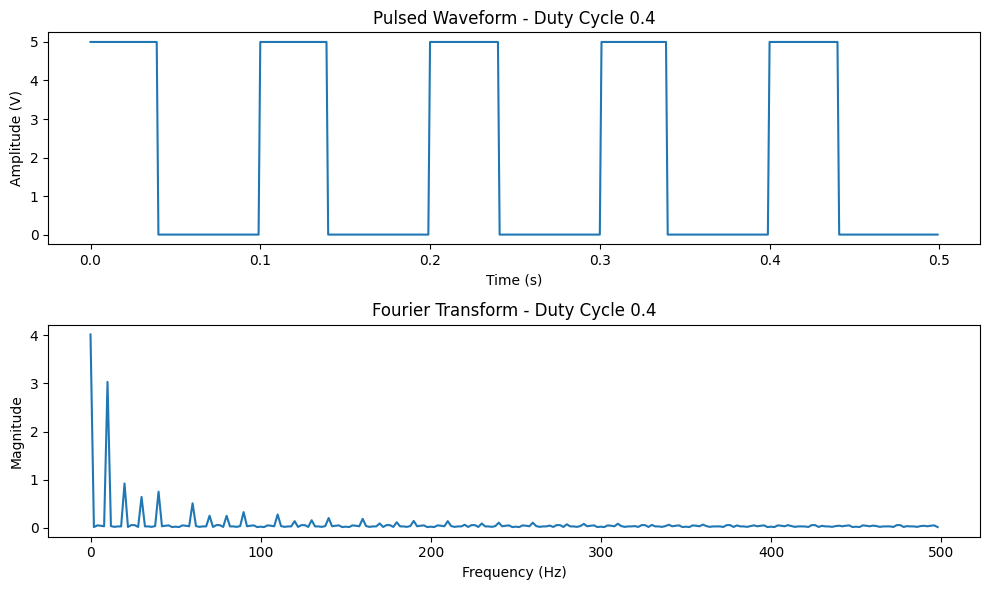

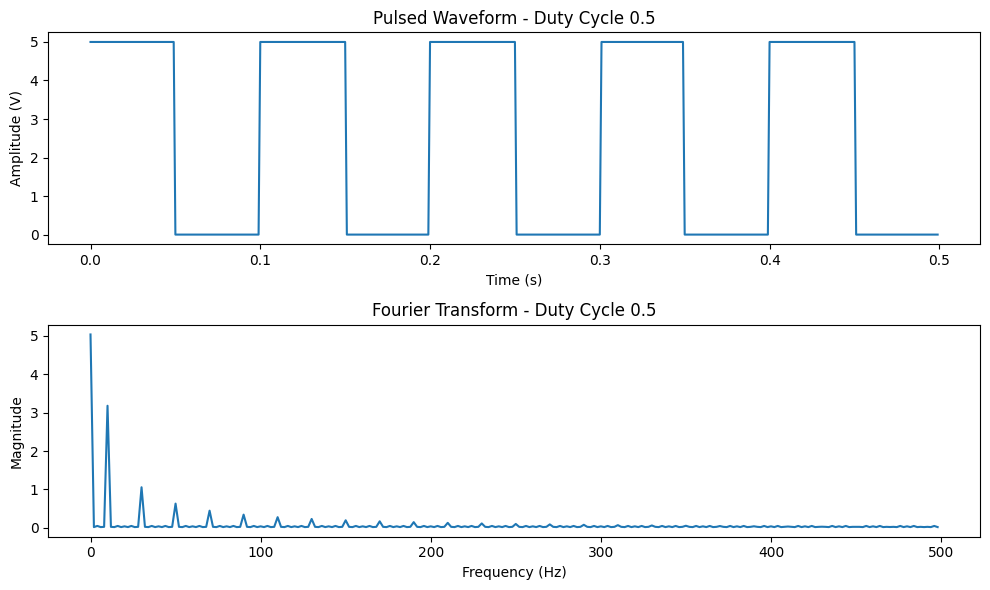

In [9]:
# Define parameters for pulsed waveform with different duty cycles
amplitude = 5
frequency = 10  # Hz
duration = 0.5  # seconds
sampling_rate = 1000  # samples per second
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Duty cycles to test
duty_cycles = [0.1, 0.2, 0.3, 0.4, 0.5]

# Function to generate a pulsed waveform based on duty cycle and plot
def plot_pulse_waveform_duty_cycle(duty_cycle):
    # Generate pulse train for given duty cycle
    pulse_waveform = (np.mod(t, 1/frequency) < duty_cycle/frequency).astype(float) * amplitude

    # Compute Fourier Transform
    N = len(pulse_waveform)
    yf = fft(pulse_waveform)
    xf = fftfreq(N, 1 / sampling_rate)[:N // 2]

    # Plot time-domain and frequency-domain
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
    ax1.plot(t, pulse_waveform)
    ax1.set_title(f"Pulsed Waveform - Duty Cycle {duty_cycle}")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Amplitude (V)")

    ax2.plot(xf, 2.0 / N * np.abs(yf[:N // 2]))
    ax2.set_title(f"Fourier Transform - Duty Cycle {duty_cycle}")
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("Magnitude")
    plt.tight_layout()
    plt.show()

# Plot for each duty cycle
for duty_cycle in duty_cycles:
    plot_pulse_waveform_duty_cycle(duty_cycle)


# Question 3

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 58, 173, 32)       896       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 29, 86, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 27, 84, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 13, 42, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 11, 40, 128)       73856  

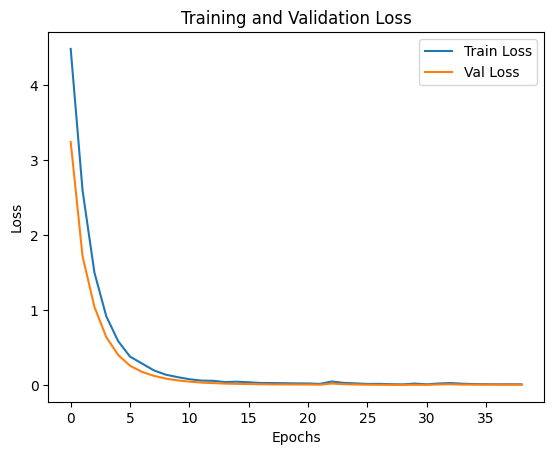

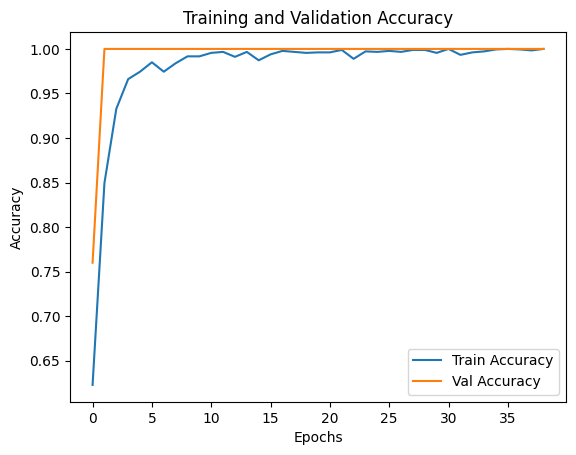

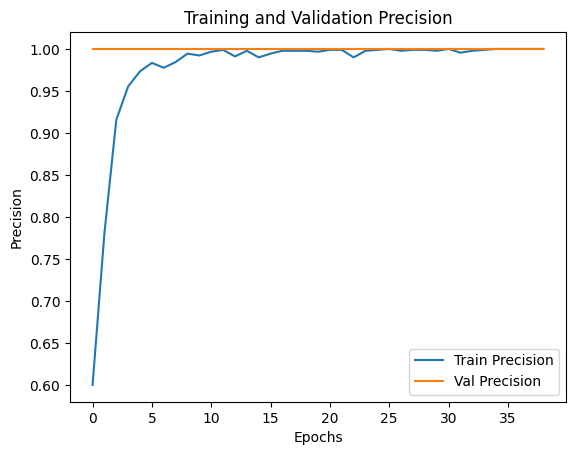

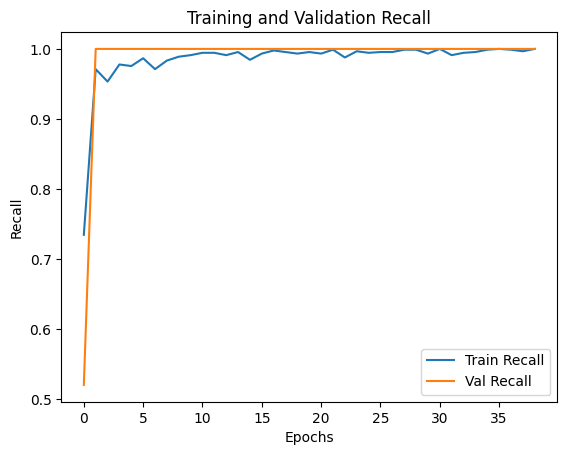

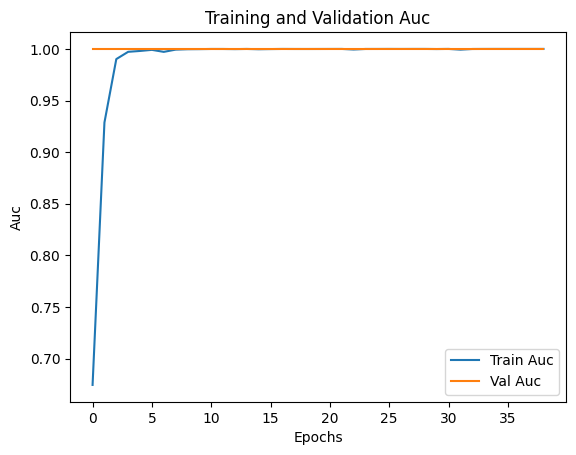

7/7 [==============================] - 0s 33ms/step


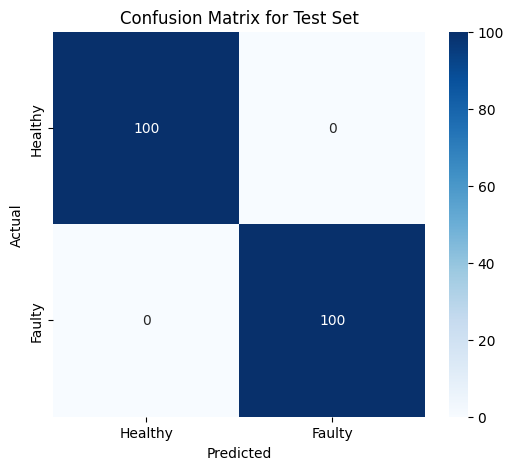

              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       100
      Faulty       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [20]:
# Define paths
train_directory = r'C:\Users\devTe\Downloads\Data_fault_classification-2\Data_fault_classification\training'
val_directory = r'C:\Users\devTe\Downloads\Data_fault_classification-2\Data_fault_classification\validation'
test_directory = r'C:\Users\devTe\Downloads\Data_fault_classification-2\Data_fault_classification\testing'

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# %% [markdown]
# ### 3. Set Up Data Generators with Augmentation for Training

# %%
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# For validation and test sets, no augmentation, just rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(60, 175),
    batch_size=32,
    class_mode='binary'
)

# Validation generator
val_generator = val_test_datagen.flow_from_directory(
    val_directory,
    target_size=(60, 175),
    batch_size=32,
    class_mode='binary'
)

# Test generator (without shuffling to preserve order for evaluation)
test_generator = val_test_datagen.flow_from_directory(
    test_directory,
    target_size=(60, 175),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# %% [markdown]
# ### 4. Define CNN Model with Regularization, Dropout, and Custom Metrics

# %%
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
]

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(60, 175, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=METRICS)

model.summary()

# %% [markdown]
# ### 5. Configure Callbacks and Train the Model

# %%
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler, tensorboard_callback]
)

# %% [markdown]
# ### 6. Plot Training and Validation Metrics

# %%
def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
    for metric in metrics:
        plt.plot(history.history[metric], label=f'Train {metric.capitalize()}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric.capitalize()}')
        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_metrics(history)

# %% [markdown]
# ### 7. Evaluate Model on Test Set and Display Confusion Matrix

# %%
# Predict on test set
y_test_pred = (model.predict(test_generator) > 0.5).astype("int32").flatten()
y_test_true = test_generator.classes

# Confusion matrix
conf_mat_test = confusion_matrix(y_test_true, y_test_pred)

# Plot confusion matrix for test set
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Faulty'], yticklabels=['Healthy', 'Faulty'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Print classification report for test set
print(classification_report(y_test_true, y_test_pred, target_names=['Healthy', 'Faulty']))

# %% [markdown]
# ### 8. Save and Load Model if Needed

# %%
# Save model
model.save("fault_classification_model.h5")

# Load model (optional)
# model = tf.keras.models.load_model("fault_classification_model.h5")